In [1]:
import matplotlib.pyplot as plt
import numpy as np
from NeedALight.propagator import Hprop, Total_prog, JSA, SXPM_prop
from scipy.linalg import expm

Parameters and function definitions (pulse and energy density). Increasing the number of frequency values really increases run time. N=101 take me a few minutes to run and the results are not to gritty.

In [2]:
#Parameters for calculations

N = 151  # Number of frequency values: Always choose a number ending in 1. That way you always have a frequency value = 0
Np = 0.04# Number of pump photons: Vary this to modify gain values 0.000002  0.0172
vp = 0.1  # pump velocity
l = 1.0  # amplification region length
sig = 1  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

y=1 #Value for squeezing interaction, previously always set to 1 and varied strength through Np
spm = 0 #Value of self-phase modulation for pump
xpms = 1 #value of cross-phase modulation for signal
xpmi = 0 #Value of cross-phase modulation for idler

#Ensuring that we are in the symmetric velocity group matching regime.
def symmetric_v(vp, sig, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sig))
    vs = vp / (1 + 2 * a * vp / (l * sig))
    return vs, vi

vs, vi = symmetric_v(vp, sig, l, a)

#Frequency values: Note the larger range, this is for SPM considerations
wi = -30
wf = 30
dw = (wf - wi) / (N - 1)
w = np.linspace(wi, wf, N)

#Unpoled domain
dz=l/1000
domain = np.arange(-l/2,l/2,dz)

#Defining gaussian pump pulse. Note that now this includes Np in definition
def pump(x):
    return np.sqrt(Np)*np.exp(-((x) ** 2) / (2 * (sig) ** 2)) / np.power(np.pi * sig**2, 1 / 4)

#Defining energy density function for gaussian pump pulse. Note that now this includes Np in definition
def density(x):
    return Np * np.exp(-((x) ** 2) / (4 * (sig) ** 2))

#For the the case where we dont S-X-PM
def pump2(x):
    return np.exp(-((x) ** 2) / (2 * (sig) ** 2)) / np.power(np.pi * sig**2, 1 / 4)
domain2=np.asarray([1])

This generates everything without SPM nor XPM using the previously developed code. The printed value is the Schmidt number.

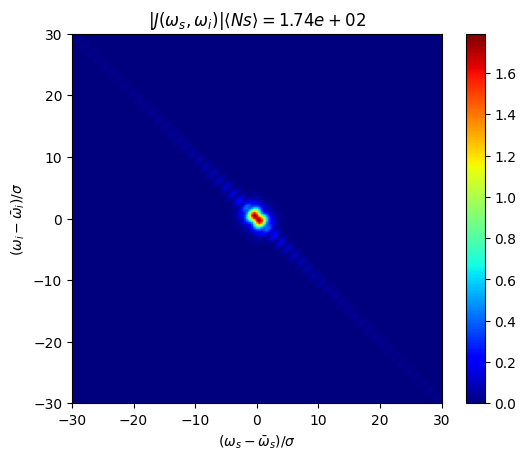

1.0200572188038677


In [4]:
#Generating the JSA without S-X-PM
prod1, P1, Nm1  = Hprop(Np, vs, vi, vp, l, w, pump2,1)  #This generates heisenberg propagators with different signs for length "l"
T1 = Total_prog(domain2, prod1, P1, Nm1) #This generates the total propagator given a specific domain.
J, Ns, K, M, Nums, Numi = JSA(T1, vs, vi, vp, l, w) #Generates the JSA as well as other relevant properties.

#Generating plot of JSA
fig, ax = plt.subplots()
im = ax.imshow(np.abs(J), cmap="jet", origin="lower",extent=[w[0],w[N-1],w[0],w[N-1]])
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
ax.set_title(r"$|J(\omega_{s}, \omega_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()
print(K)

This generates everything for the SPM and XPM values chosesn earlier. Can also directly change them in the command line.

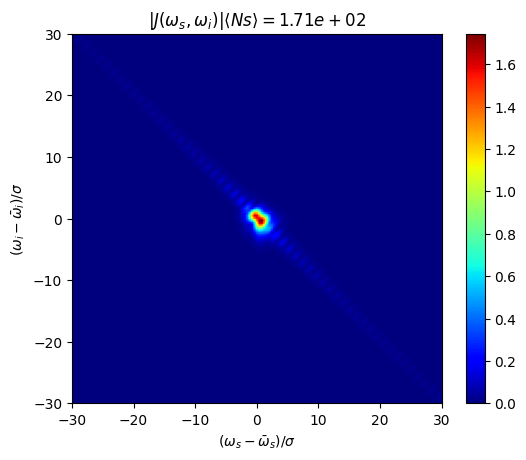

1.0211412536013253


In [5]:
#Generating the JSA with S-X-PM
T2 = SXPM_prop(vs, vi, vp, 1, spm, xpms, xpmi, pump, density, domain, w) #This generates the total propagator given a specific domain.
J, Ns, K, M, Nums, Numi = JSA(T2, vs, vi, vp, l, w) #Generates the JSA as well as other relevant properties.

#Generating plot of JSA
fig, ax = plt.subplots()
im = ax.imshow(np.abs(J), cmap="jet", origin="lower",extent=[w[0],w[N-1],w[0],w[N-1]])
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
ax.set_title(r"$|J(\omega_{s}, \omega_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()
print(K)

We include this next part to look at how the pump evolves under SPM as a verification/to see if it evolves as expected. Directly change spm2 for different strengths and look at different positions.

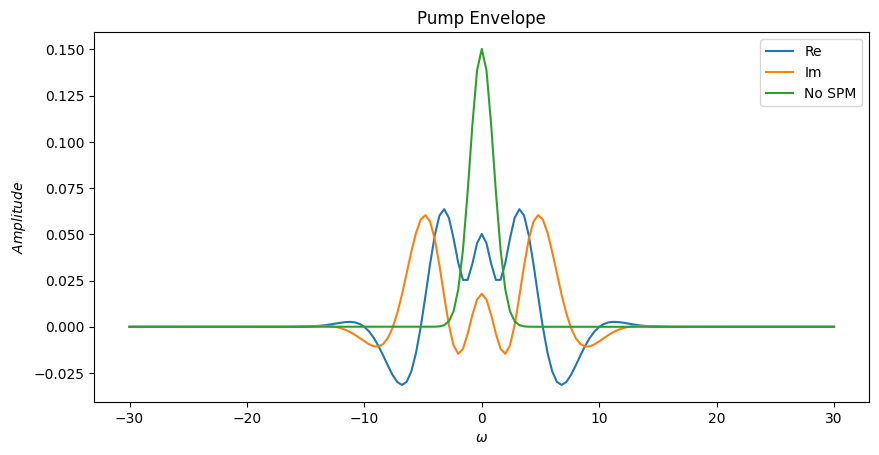

In [6]:
#Looking at the effects of SPM on the pump
spm2=0.5
pumpz = lambda x: expm( 1j * (spm2 * dw / vp ** 2) * (x-domain[0]) * density(-w +w[:,np.newaxis]))@pump(w)
z=l/2  #position of interest, chosen et end of region.

fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.plot(w,np.real(pumpz(z)), label='Re') 
ax1.plot(w,np.imag(pumpz(z)), label='Im')
ax1.plot(w,np.real(pump(w)), label='No SPM')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"Pump Envelope")
ax1.legend()
plt.show()

Next we look at how the diagonal part of the transfer matrix Uss behaves when S-XPM are EXCLUDED. Note that when isolating Uss, we remove the trival phases. Plot shows both real and imagary parts.

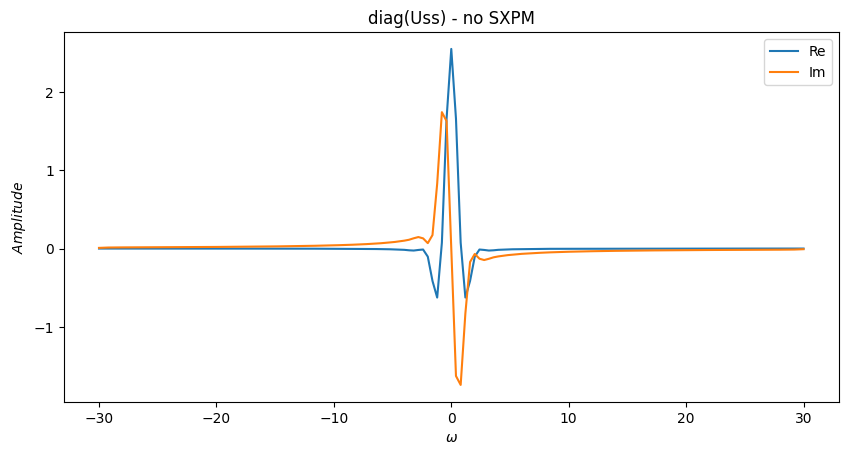

In [7]:
#Looking at the transfer function Uss without S-X-PM
N1 = len(T1)
ks = 1 / vs - 1 / vp
ki = 1 / vi - 1 / vp
Uss = (
np.diag(np.exp(-1j * ks * w * l / 2))
@ T1[0 : N1 // 2, 0 : N1 // 2]
@ np.diag(np.exp(-1j * ks * w * l / 2))
)


fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.plot(w, np.real(np.diag(Uss))-1, label='Re') 
ax1.plot(w, np.imag(np.diag(Uss)), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"diag(Uss) - no SXPM")
ax1.legend()
plt.show()

Next we look at how the diagonal part of the transfer matrix Uss behaves when XPM are INCLUDED. Note that when isolating Uss, we remove the trival phases. Plot shows both real and imagary parts. 

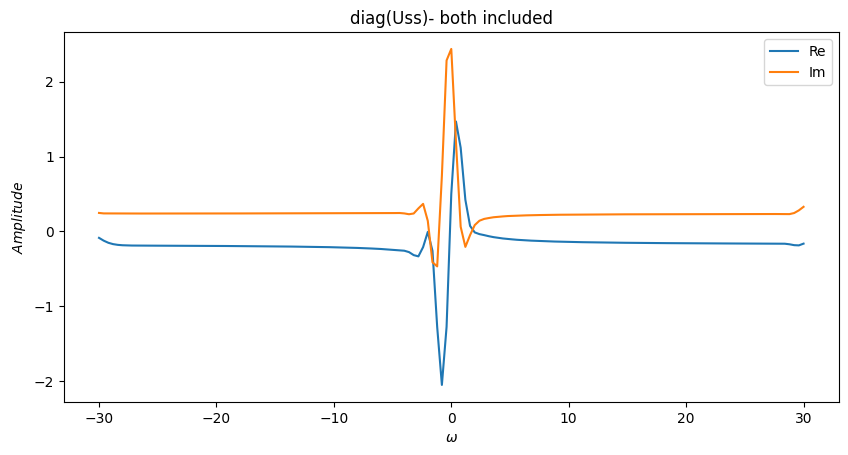

In [8]:
#Looking at the transfer function Uss without S-X-PM
N2 = len(T2)
ks = 1 / vs - 1 / vp
ki = 1 / vi - 1 / vp
UssXPM = (
np.diag(np.exp(-1j * ks * w * l / 2))
@ T2[0 : N2 // 2, 0 : N2 // 2]
@ np.diag(np.exp(-1j * ks * w * l / 2))
)



fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.plot(w, np.real(np.diag(UssXPM))-1, label='Re') 
ax1.plot(w, np.imag(np.diag(UssXPM)), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"diag(Uss)- both included")
ax1.legend()
plt.show()

Next we look at how the diagonal part of the transfer matrix Uss behaves when ONLY XPM on the signal is included. Note that when isolating Uss, we remove the trival phases. Plot shows both real and imagary parts. 

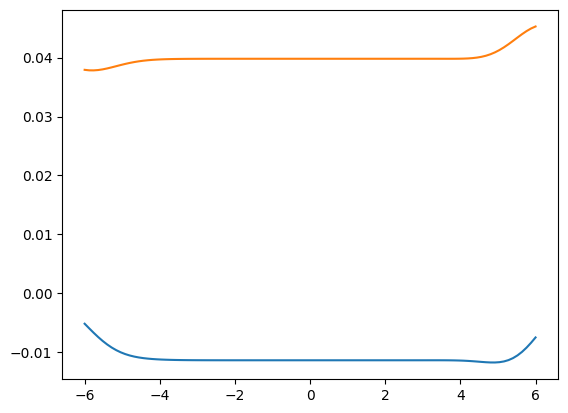

In [9]:
T4 = SXPM_prop(vs, vi, vp, 0, 0, xpms, 0, pump, density, domain, w)
N4 = len(T4)
ks = 1 / vs - 1 / vp
ki = 1 / vi - 1 / vp
UssXPMonly = (
np.diag(np.exp(-1j * ks * w * l / 2))
@ T4[0 : N2 // 2, 0 : N2 // 2]
@ np.diag(np.exp(-1j * ks * w * l / 2))
)


fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.plot(w, np.real(np.diag(UssXPMonly))-1, label='Re') 
ax1.plot(w, np.imag(np.diag(UssXPMonly)), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"diag(Uss) - no interaction")
ax1.legend()
plt.show()